In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import load
from joblib import dump
import gc

In [2]:
data_bs1 = pd.read_csv('../data/preprocessed_data_BS1.csv')
data_bs1.head()

,hg38_ASF1A,hg38_CCT7,hg38_EPOR,hg38_NECAP2,hg38_LRRC8A,hg38_NDUFS8,hg38_MRPL22,hg38_HIST1H2BC,hg38_LY96,hg38_UBE2E2-AS1,...,hg38_TMEM128,hg38_ASPSCR1,hg38_CDC20,hg38_DNAJB9,hg38_OSTM1,hg38_LCNL1,hg38_PHB,hg38_LRRC29,hg38_ZFP36,Group
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,B
1,0,0,0,3,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,B
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,2,0,3,B
3,0,0,0,0,0,3,0,0,0,0,...,0,0,0,3,0,0,3,0,0,B
4,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,B


In [3]:
X = data_bs1.drop(['Group'], axis=1)
y = data_bs1['Group']

In [4]:
y.unique()

array(['B', 'D', 'M', 'NK', 'T'], dtype=object)

In [5]:
def replace_values(y):
    return y.replace({'B': 0, 'D': 1, 'M': 2, 'NK': 3, 'T': 4}, regex=True)

In [6]:
encoded_y = replace_values(y)
encoded_y[:5], y[:5]

(0    0
 1    0
 2    0
 3    0
 4    0
 Name: Group, dtype: int64,
 0    B
 1    B
 2    B
 3    B
 4    B
 Name: Group, dtype: object)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.3, random_state=55)

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [9]:
def model_info(y_real, y_pred, labels=['B', 'D', 'M', 'NK', 'T']):
    cm = confusion_matrix(y_real, y_pred)
    class_sums = cm.sum(axis=1)
    normalized_conf_matrix = cm / class_sums[:, np.newaxis]
    sns.heatmap(normalized_conf_matrix, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='.2f')
    plt.xlabel('Predvidjene vrednosti')
    plt.ylabel('Stvarne vrednosti')
    plt.title('Matrica konfuzije')
    plt.show()

    print('Matrica konfuzije: \n', cm)
    print('Accuracy score: ', accuracy_score(y_real, y_pred))
    print('Precision score: ', precision_score(y_real, y_pred, average='weighted', zero_division=0))
    print('Recall score: ', recall_score(y_real, y_pred, average='weighted'))
    print('F1 score: ', f1_score(y_real, y_pred, average='weighted'))

In [10]:
def build_model(model, X_train, X_test, y_train, y_test, classes=['B', 'D', 'M', 'NK', 'T']):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    model_info(y_test, y_pred, classes)

    return model

In [11]:
from xgboost import XGBClassifier

model_bs1 = XGBClassifier(random_state=55)

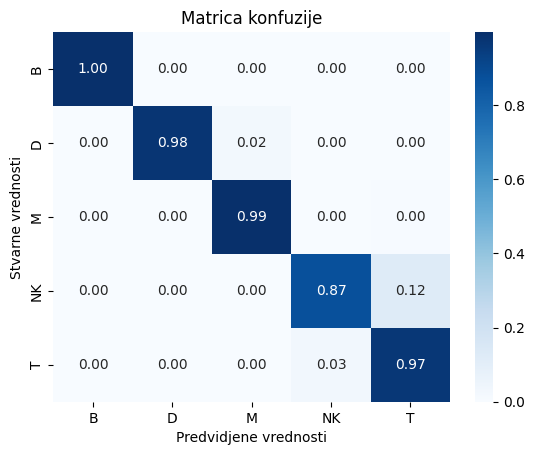

Matrica konfuzije: 
 [[ 516    0    1    0    1]
 [   0   40    1    0    0]
 [   0    1  493    0    2]
 [   1    0    0  342   49]
 [   1    0    1   80 2426]]
Accuracy score:  0.9651074589127686
Precision score:  0.966386261400732
Recall score:  0.9651074589127686
F1 score:  0.9656112385929325


In [12]:
model_bs1 = build_model(model_bs1, X_train, X_test, y_train, y_test)

In [13]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

model = XGBClassifier(random_state=55)
grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=3, verbose=1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = XGBClassifier(**best_params, random_state=55)
best_model.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [14]:
best_params, best_score

({'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300},
 0.9604464672735155)

In [15]:
del model_bs1
del model
gc.collect()

7136

In [12]:
best_params = {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}
best_model = XGBClassifier(**best_params, random_state=55)
best_model.fit(X_train, y_train)
dump(best_model, 'xg.joblib')

['xg.joblib']

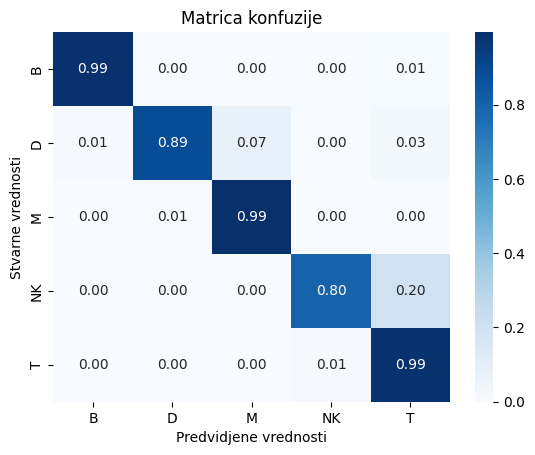

Matrica konfuzije: 
 [[ 585    0    0    0    6]
 [   1   71    6    0    2]
 [   0    3  593    0    0]
 [   0    0    0  216   54]
 [   1    0    2   26 2078]]
Accuracy score:  0.9722832052689352
Precision score:  0.9716678085018201
Recall score:  0.9722832052689352
F1 score:  0.971718350494811

--------------------------------------



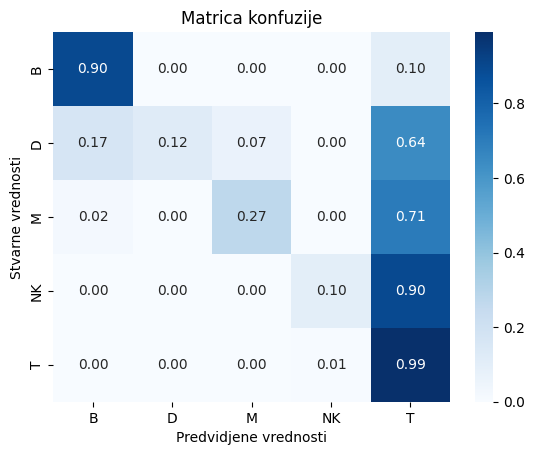

Matrica konfuzije: 
 [[1683    0    0    0  194]
 [  45   33   18    0  174]
 [  41    0  549    0 1416]
 [   0    0    0   88  754]
 [  17    0    2   43 7089]]
Accuracy score:  0.7773752675778034
Precision score:  0.8073124679908543
Recall score:  0.7773752675778034
F1 score:  0.7273297671631006


13665

In [44]:
data_bs2 = pd.read_csv('../data/preprocessed_data_BS2.csv')

X = data_bs2.drop(['Group'], axis=1)
y = data_bs2['Group']
encoded_y = replace_values(y)

X_train_bs2, X_test_bs2, y_train_bs2, y_test_bs2 = train_test_split(X, encoded_y, test_size=0.3, random_state=55)

model_bs2 = XGBClassifier(random_state=55)
model_bs2 = build_model(model_bs2, X_train_bs2, X_test_bs2, y_train_bs2, y_test_bs2)
print('\n--------------------------------------\n')

X_test_data = data_bs2.drop(['Group'], axis=1)
y_test_data = data_bs2['Group']
encoded_y_test_data = replace_values(y_test_data)

y_pred = best_model.predict(X_test_data)
model_info(encoded_y_test_data, y_pred)

del X, y, encoded_y
del X_train_bs2, X_test_bs2, y_train_bs2, y_test_bs2
del model_bs2
del y_pred
gc.collect()

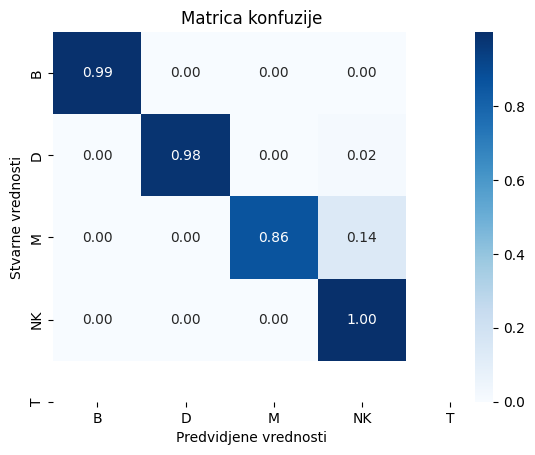

Matrica konfuzije: 
 [[ 513    1    0    2]
 [   0  258    0    5]
 [   0    0   68   11]
 [   1    1    0 4062]]
Accuracy score:  0.9957334416903698
Precision score:  0.9957423039946431
Recall score:  0.9957334416903698
F1 score:  0.9956489479403883

--------------------------------------



C:\Users\bogda\AppData\Local\Temp\ipykernel_748\1779981008.py:4: RuntimeWarning: invalid value encountered in divide
  normalized_conf_matrix = cm / class_sums[:, np.newaxis]


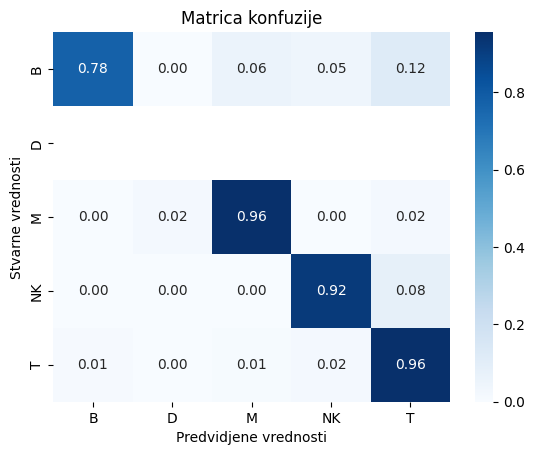

C:\Users\bogda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matrica konfuzije: 
 [[ 1361     1   103    81   210]
 [    0     0     0     0     0]
 [    3    17   818     2    16]
 [    0     0     0   283    26]
 [  199    12   106   288 12879]]
Accuracy score:  0.9351417250838159
Precision score:  0.9490882574606972
Recall score:  0.9351417250838159
F1 score:  0.9396700997512083


12764

In [13]:
data_geo = pd.read_csv('../data/preprocessed_data_GEO.csv')

X = data_geo.drop(['Group'], axis=1)
y = data_geo['Group']
encoded_y = y.replace({'B': 0, 'M': 1, 'NK': 2, 'T': 3}, regex=True)

X_train_geo, X_test_geo, y_train_geo, y_test_geo = train_test_split(X, encoded_y, test_size=0.3, random_state=55)

model_geo = XGBClassifier(**best_params, random_state=55)
model_geo = build_model(model_geo, X_train_geo, X_test_geo, y_train_geo, y_test_geo)
print('\n--------------------------------------\n')


y_pred = best_model.predict(X)
model_info(replace_values(y), y_pred)

del X, y, encoded_y
del X_train_geo, X_test_geo, y_train_geo, y_test_geo
del model_geo
del y_pred
gc.collect()

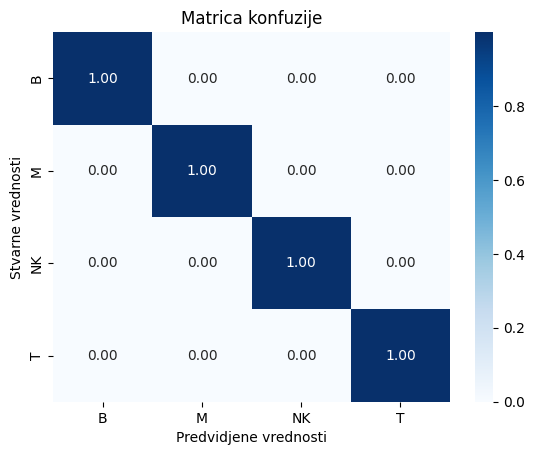

Matrica konfuzije: 
 [[ 2950     0     0     1]
 [    1   535     0     1]
 [    0     1  2409     7]
 [    4     0     4 18816]]
Accuracy score:  0.9992316713170771
Precision score:  0.9992316207632905
Recall score:  0.9992316713170771
F1 score:  0.9992315051440767

--------------------------------------



C:\Users\bogda\AppData\Local\Temp\ipykernel_748\1779981008.py:4: RuntimeWarning: invalid value encountered in divide
  normalized_conf_matrix = cm / class_sums[:, np.newaxis]


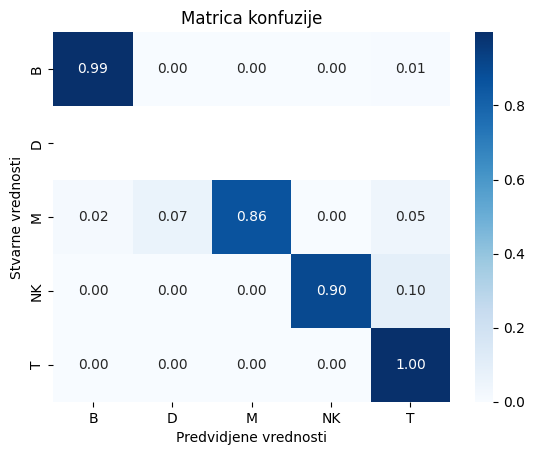

Matrica konfuzije: 
 [[ 9672     0     0     0    53]
 [    0     0     0     0     0]
 [   35   122  1595     3    93]
 [    0     0     0  7396   783]
 [   53    14     1    62 62546]]
Accuracy score:  0.9852113359538021
Precision score:  0.986929155097157
Recall score:  0.9852113359538021
F1 score:  0.9857296388920562


C:\Users\bogda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12600

In [14]:
data_10x = pd.read_csv('../data/preprocessed_data_10x.csv')

X = data_10x.drop(['Group'], axis=1)
y = data_10x['Group']
encoded_y = y.replace({'B': 0, 'M': 1, 'NK': 2, 'T': 3}, regex=True)

X_train_10x, X_test_10x, y_train_10x, y_test_10x = train_test_split(X, encoded_y, test_size=0.3, random_state=55)

model_10x = XGBClassifier(**best_params)
model_10x = build_model(model_10x, X_train_10x, X_test_10x, y_train_10x, y_test_10x, classes=['B', 'M', 'NK', 'T'])
print('\n--------------------------------------\n')

y_pred = best_model.predict(X)
model_info(replace_values(y), y_pred)

del X, y, encoded_y
del X_train_10x, X_test_10x, y_train_10x, y_test_10x
del model_10x
del y_pred
gc.collect()

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

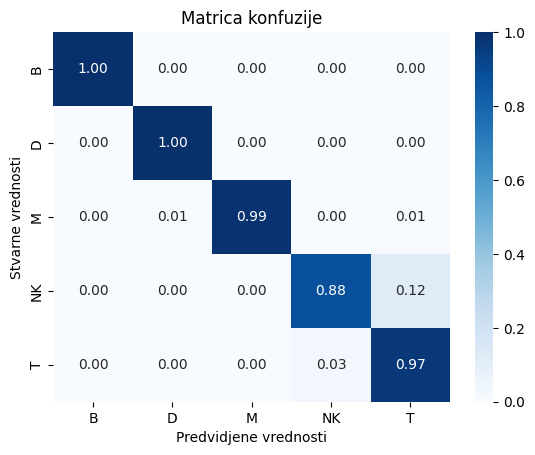

Matrica konfuzije: 
 [[ 517    0    1    0    0]
 [   0   41    0    0    0]
 [   0    3  490    0    3]
 [   1    0    0  343   48]
 [   1    0    1   79 2427]]
Accuracy score:  0.9653603034134007
Precision score:  0.9666727734984888
Recall score:  0.9653603034134007
F1 score:  0.9658659427990096


['xg_over.joblib']

In [13]:
train_data = pd.read_csv('../data/oversampled_train_BS1.csv')
X_train = train_data.drop(['Group'], axis=1)
y_train = train_data['Group']
y_train = replace_values(y_train)
test_data = pd.read_csv('../data/oversampled_test_BS1.csv')
X_test = test_data.drop(['Group'], axis=1)
y_test = test_data['Group']
y_test = replace_values(y_test)
best_params = {
    'learning_rate': 0.2,
    'max_depth': 4,
    'n_estimators': 300
}
model = XGBClassifier(**best_params, random_state=55)
build_model(model, X_train, X_test, y_train, y_test)
dump(model, 'xg_over.joblib')

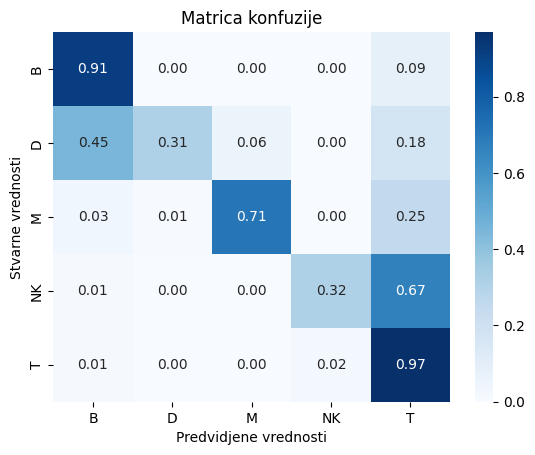

Matrica konfuzije: 
 [[1715    0    0    0  162]
 [ 121   85   16    0   48]
 [  70   13 1421    0  502]
 [  12    0    0  266  564]
 [  82    0    1  138 6930]]
Accuracy score:  0.8576486085954224
Precision score:  0.8578487310781865
Recall score:  0.8576486085954224
F1 score:  0.8442370288936526


In [8]:
data_bs2 = pd.read_csv('../data/preprocessed_data_BS2.csv')

X = data_bs2.drop(['Group'], axis=1)
y = data_bs2['Group']
y = replace_values(y)

y_pred = model.predict(X)
model_info(y, y_pred)

C:\Users\bogda\AppData\Local\Temp\ipykernel_13296\1779981008.py:4: RuntimeWarning: invalid value encountered in divide
  normalized_conf_matrix = cm / class_sums[:, np.newaxis]


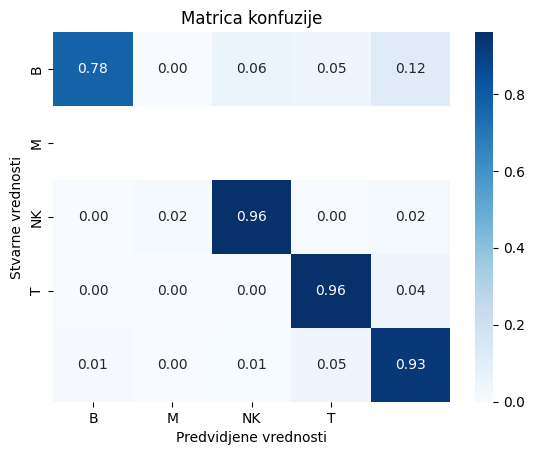

Matrica konfuzije: 
 [[ 1362     1   105    80   208]
 [    0     0     0     0     0]
 [    3    14   822     4    13]
 [    0     0     0   296    13]
 [  193    13   110   646 12522]]
Accuracy score:  0.9144772935080768
Precision score:  0.9472361599203201
Recall score:  0.9144772935080768
F1 score:  0.9261330545305526


C:\Users\bogda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
data_geo = pd.read_csv('../data/preprocessed_data_GEO.csv')

X = data_geo.drop(['Group'], axis=1)
y = data_geo['Group']
y = replace_values(y)

y_pred = model.predict(X)
model_info(y, y_pred, labels=['B', 'M', 'NK', 'T'])

C:\Users\bogda\AppData\Local\Temp\ipykernel_13296\1779981008.py:4: RuntimeWarning: invalid value encountered in divide
  normalized_conf_matrix = cm / class_sums[:, np.newaxis]


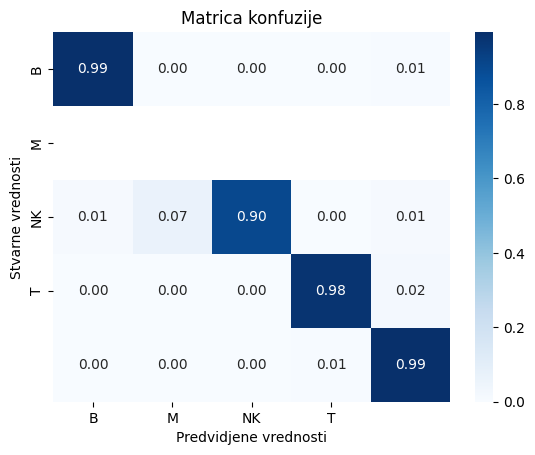

Matrica konfuzije: 
 [[ 9656     0    15     0    54]
 [    0     0     0     0     0]
 [   25   129  1665     3    26]
 [    0     1     1  7989   188]
 [   29    16    26   390 62215]]
Accuracy score:  0.9890449847139322
Precision score:  0.9908785536817891
Recall score:  0.9890449847139322
F1 score:  0.9899124273224158


C:\Users\bogda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
data_10x = pd.read_csv('../data/preprocessed_data_10x.csv')

X = data_10x.drop(['Group'], axis=1)
y = data_10x['Group']
y = replace_values(y)

y_pred = model.predict(X)
model_info(y, y_pred, labels=['B', 'M', 'NK', 'T'])